## 実習6-1
### 画像からノイズを除去する
#### (https://qiita.com/cvusk/items/9b822860bb2c501a0fe4 )が参考になります。

In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation
from keras import layers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import os
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
batch_size = 50
num_classes = 10
epochs = 5 #10ぐらいあってもよいですが、授業時間の関係で5にしてます。

In [3]:
# イメージサイズの設定
img_rows, img_cols = 32, 32

In [4]:
# CIFAR-10データをダウンロード。既に訓練データとテストデータに分割されている。
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 4s 0us/step
50000 train samples
10000 test samples


In [5]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 1)
#"channels_first"の場合、入力のshapeは(batch, channels, row, column)となり,
#"channels_last"の場合，入力のshapeは(batch, row, column, channels)となります。

In [6]:
#データの値を正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [7]:
#画像にごま塩ノイズを作る
from numpy.random import rand
from itertools import product

def saltpepper(input, salt=0.05, pepper=0.05):
    """
    引数
    input : np.3darrayで、各要素は[0,1]内のfloat32の数
    salt : 白ノイズピクセル発生数の割合
    pepper : 黒ノイズピクセル発生数の割合
    
    返り値
    noisy : 入力に白黒ノイズを加えた画像(np.3darray)
    """
    height, width, ch = input.shape
    
    # random_maskはshape=(height, width)の[0,1]上の一様乱数テンソル
    random_mask = rand(height, width)
    
    # noisyに結果を当てはめる
    noisy = np.zeros(shape=input.shape)
    for h, w in product(range(height), range(width)):
        if random_mask[h, w] > 1-salt: #値が1-saltより大きいところは1(白)にする
            noisy[h, w, :] = 1
        elif random_mask[h, w] < pepper: #値がpepperより小さいところは0(黒)にする
            noisy[h, w, :] = 0
        else:
            noisy[h, w, :] = input[h, w, :] #上記以外の場所は変化なし
    return noisy

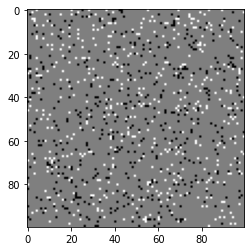

In [8]:
#どんなノイズができるか確認
img = 0.5*np.ones((100, 100, 3))
img = saltpepper(img, salt=0.05, pepper=0.05)
plt.imshow(img)

ガウシアンノイズ

In [9]:

#画像にガウシアンノイズを与える
def addGaussianNoise(input, mean=0, sigma=0.1):
    """
    引数
    input : np.3darrayで、各要素は[0,1]内のfloat32の数
    mean : ノイズの平均パラメータ
    sigma : ノイズの分散パラメータ
    
    返り値
    noisy : 入力画像
    """
    row,col,ch= input.shape
    
    # gauss : 平均mean、分散sigmaである正規乱数の3階テンソル。shape=(row,col,ch)である。
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    
    # 入力画像に正規乱数を足し合わせる。画像ピクセルは0以上1未満でなければならないのでclipする。
    noisy = input + gauss
    noisy = np.clip(noisy, 0, 1)
    return noisy

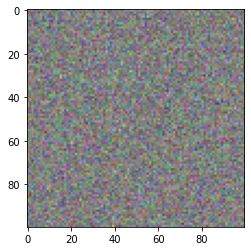

In [10]:
#どんなノイズができるか確認
img = 0.5*np.ones((100, 100, 3))
img = addGaussianNoise(img, mean=0, sigma=0.1)
plt.imshow(img)

ごま塩ノイズのイメージデータジェネレータ

In [11]:
class NoisedImageDataGenerator(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.images = []
        self.labels = []

    def flow(self, data, batch_size=32):
        """
        引数dataはcifar10のx_trainを代入する。
        """
        while True:
            for array in data:
                self.images.append(saltpepper(array, salt=0.05, pepper=0.05))
                self.labels.append(array)
                if len(self.images) == batch_size:
                    inputs = np.asarray(self.images, dtype=np.float32)[:,:,:]
                    targets = np.asarray(self.labels, dtype=np.float32)[:,:,:]
                    self.reset()
                    yield inputs, targets #generatorではyield

モデル

In [12]:
#modelを関数として実装
def win5rb(input_tensor=None, input_shape=None, filters=64, kernel_size=5, iters=3):
    """
    filters : Conv2Dのフィルター数
    kernel_size : Conv2Dのカーネルサイズ（整数の組もしくは整数）
    iters : Conv2D, BatchNormalization, Activationを何回繰り替えすかを指定する。このレイヤー部分はiter+1回積み重ねられる。
    """
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor): #input_tensorがKerasのテンソルかどうかを返す。「Kerasのテンソル」とはKerasのレイヤー（Layerクラス）やInputから返されたテンソルです。
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    output_channels = input_shape[2]

    x = Conv2D(filters, kernel_size, padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for l in range(iters):
        x = Conv2D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    x = Conv2D(output_channels, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    output_img = layers.add([x, img_input]) #skip connection

    model = Model(img_input, output_img,name='win5rb')
    return model

In [13]:
model = win5rb(input_shape=x_train[0].shape, iters=3) #x_train[0].shapeは(32, 32, 3)
model.summary()

Model: "win5rb"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 64)   0           batch_normalization[0][0]        
_____________________________________________________________________________________________

学習

In [14]:
model = win5rb(input_shape=x_train[0].shape)
model.compile(optimizer='adam', loss='mean_squared_error')

start = time.time()

train_datagen = NoisedImageDataGenerator()
validation_datagen = NoisedImageDataGenerator()

#重みを保存するディレクトリ作成
denoising_results_dir = 'saved_model_denoising'
if not os.path.exists(denoising_results_dir):os.mkdir(denoising_results_dir)

#modelcheckpointを使ってval_lossが最小になった時に重みを保存する設定にするにはsave_best_only=Trueに変更
mc=ModelCheckpoint(os.getcwd()+'/saved_model_denoising/epoch{epoch:02d}.h5', 
                   monitor='val_loss', 
                   verbose=0, 
                   save_best_only=False, 
                   save_weights_only=False, 
                    mode='auto', period=1)

#学習
hist = model.fit_generator(train_datagen.flow(data=x_train, batch_size=batch_size),
                           steps_per_epoch = 50000/batch_size, #1epochで用いるminibatchの数
                           epochs=epochs,
                           validation_data=validation_datagen.flow(data=x_test, batch_size=batch_size),
                           validation_steps=len(x_test)//batch_size+1,
                           workers=1, callbacks=[mc])

elapsed_time = time.time() - start #(処理時間)＝(処理が終わった時間)ー(処理を始めた時間)
print("計算時間:",elapsed_time,"秒") 

# test data（＝validation data）に対するlossを出す
x_test_noised = np.array([saltpepper(x, salt=0.05, pepper=0.05) for x in x_test])
scores = model.evaluate(x_test_noised, x_test, verbose=0)
print('Test loss:', scores)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
1000/1000 [==============================] - 108s 101ms/step - loss: 0.4172 - val_loss: 0.0274
Epoch 2/5
1000/1000 [==============================] - 101s 101ms/step - loss: 0.0093 - val_loss: 3.5933e-04
Epoch 3/5
1000/1000 [==============================] - 101s 101ms/step - loss: 2.9075e-04 - val_loss: 3.5359e-04
Epoch 4/5
1000/1000 [==============================] - 100s 100ms/step - loss: 2.4173e-04 - val_loss: 2.3788e-04
Epoch 5/5
1000/1000 [==============================] - 100s 100ms/step - loss: 2.1637e-04 - val_loss: 2.4894e-04
計算時間: 511.5330979824066 秒
Test loss: 0.0002497277164366096


学習結果のプロット

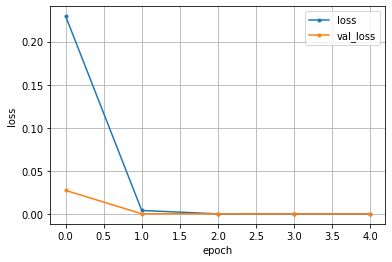

In [15]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

# lossのグラフ
plt.plot(range(epochs), loss, marker='.', label='loss')
plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

予測結果

In [16]:
# modelの予測値を出力
preds = model.predict(x_test_noised)
print(preds.shape)

(10000, 32, 32, 3)


並べた画像の保存先を設定し、保存

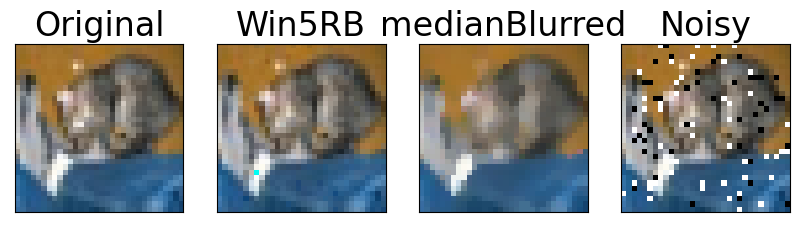

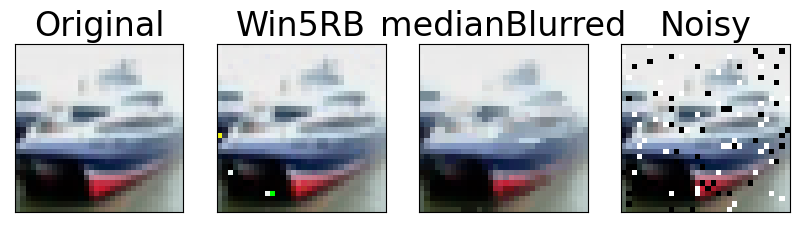

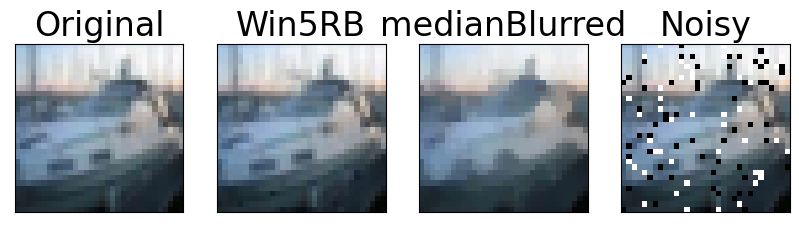

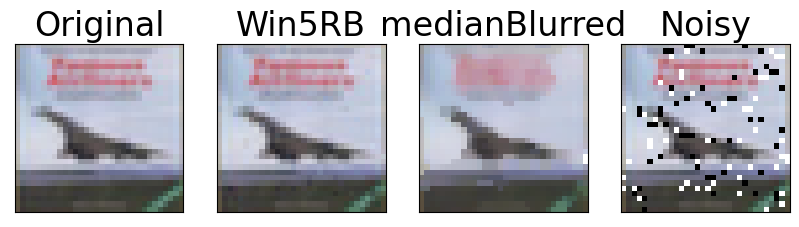

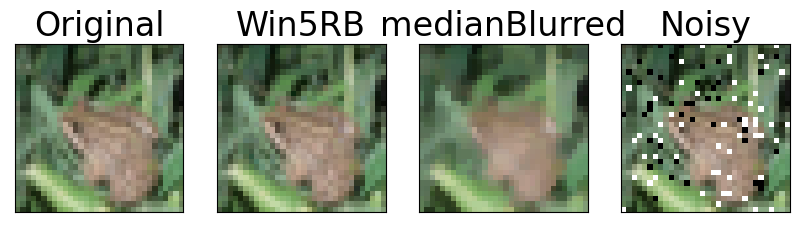

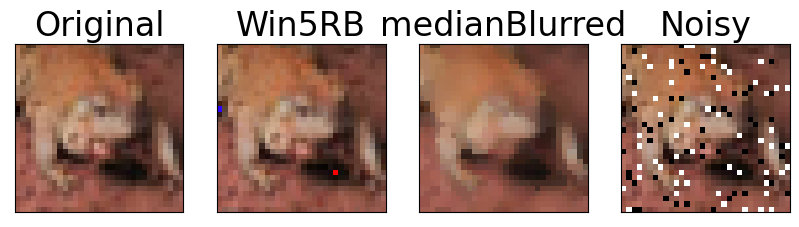

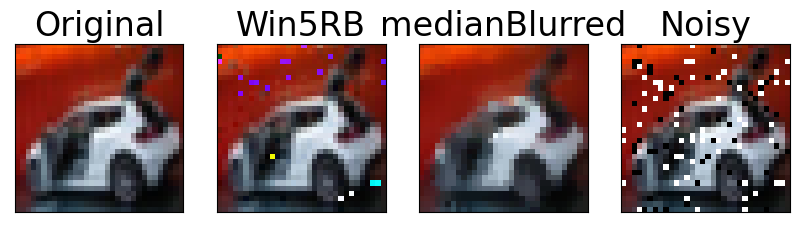

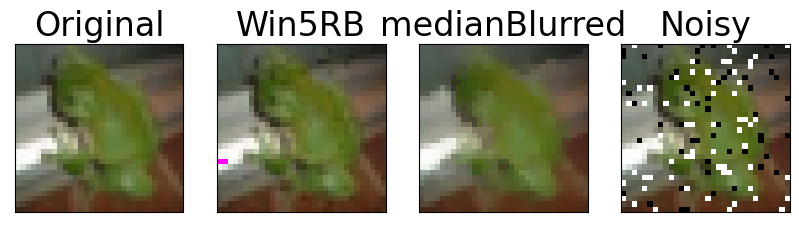

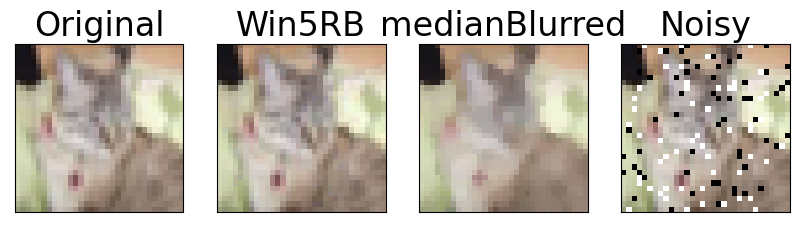

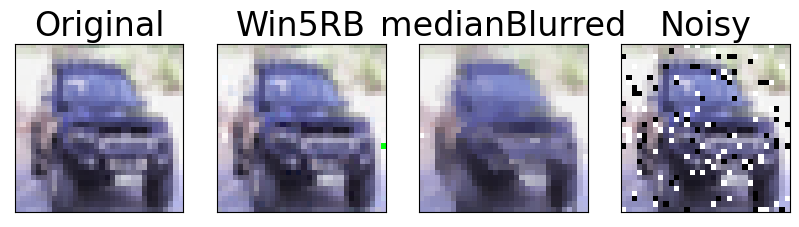

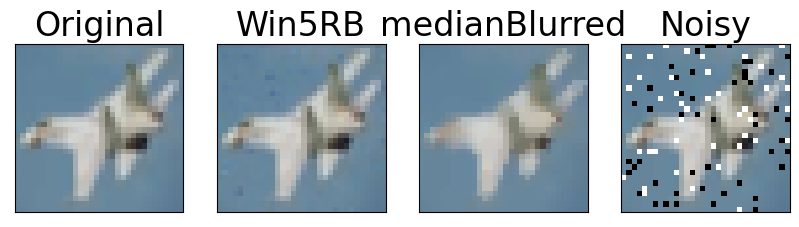

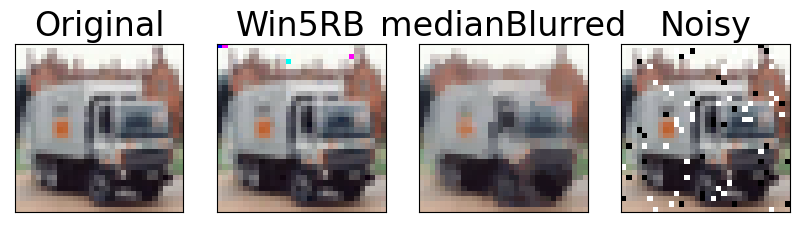

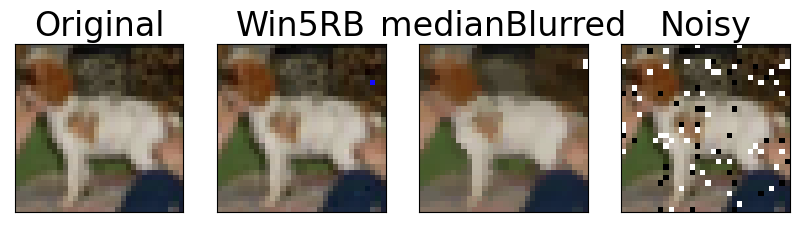

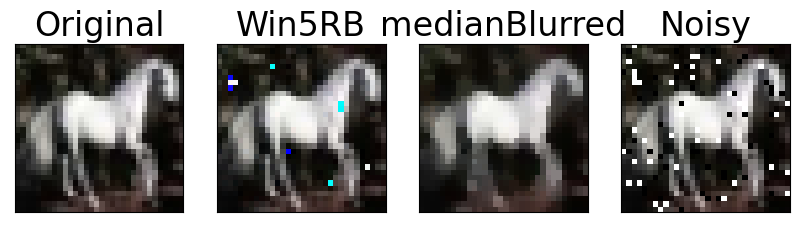

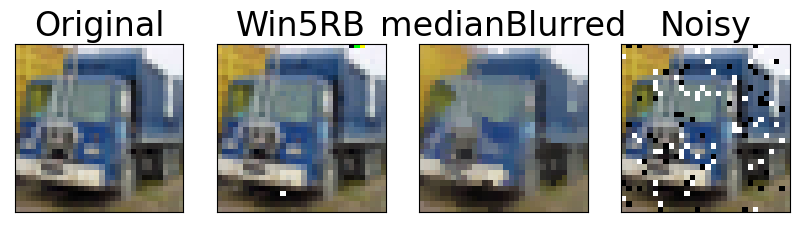

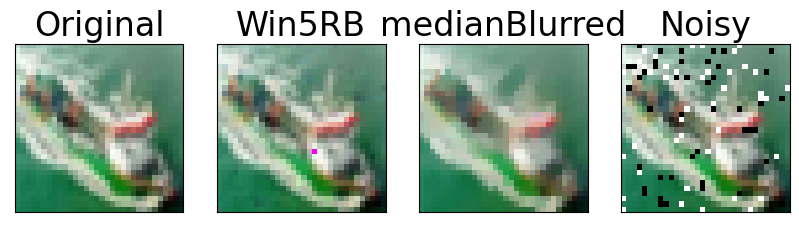

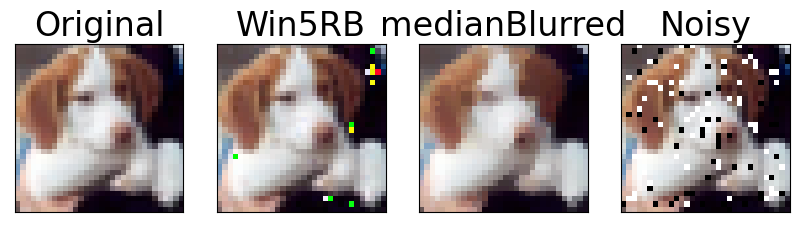

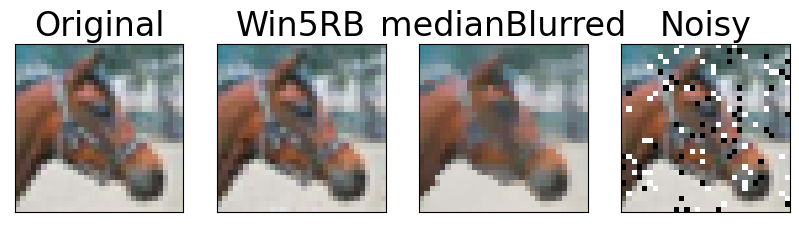

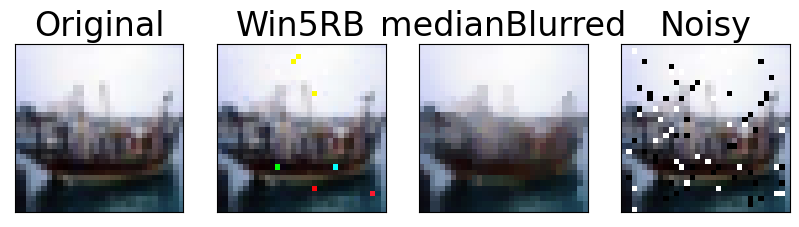

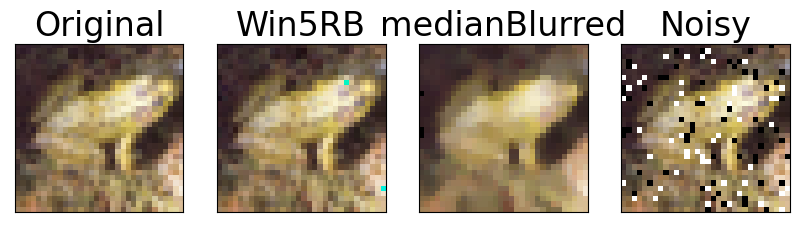

In [17]:
import cv2
from keras.models import load_model
import matplotlib.pyplot as plt
import pathlib

#学習済みの重みを呼び出して、ノイズ低減画像を出力
mdl = load_model(os.getcwd() + '/saved_model_denoising/epoch{:02d}.h5'.format(5), compile=False)
preds = mdl.predict(x_test_noised)

#メディアンブラーを追加した画像の保存先を作成
pathlib.Path(os.getcwd()+"/salt_images_blurred").mkdir(exist_ok=True)

n=0
for n in range(20):
    img = x_test_noised[n]
    img = np.array(img, dtype='float32')
    blur = cv2.medianBlur(img,3)

    plt.figure(figsize=(10, 10), dpi=100)
    plt.rcParams["font.size"] = 20
    plt.subplot(141),plt.imshow((x_test[n]*255).astype(np.uint8)),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(142),plt.imshow((preds[n]*255).astype(np.uint8)),plt.title('Win5RB')
    plt.xticks([]), plt.yticks([])
    plt.subplot(143),plt.imshow((blur*255).astype(np.uint8)),plt.title('medianBlurred')
    plt.xticks([]), plt.yticks([])
    plt.subplot(144),plt.imshow((img*255).astype(np.uint8)),plt.title('Noisy')
    plt.xticks([]), plt.yticks([])

    #plt.show()
    plt.savefig(os.getcwd() + "/salt_images_blurred/image"+format(n)+".png")

## おまけ

アニメーションの作り方

 - エポックごとに作成した重みを読み込みそれぞれに対して予測画像を生成
 - matplotlibのアニメーション機能でgif化

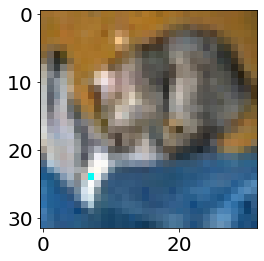

In [18]:
# アニメーション
import matplotlib.animation as animation
n = 0
ims = []
fig = plt.figure()
for i in range(5):
    mdl = load_model(os.getcwd() + '/saved_model_denoising/epoch{:02d}.h5'.format(i+1), compile=False)
    preds = mdl.predict(x_test_noised)
    im = plt.imshow((preds[0]*255).astype(np.uint8))
    ims.append([im])

In [19]:
#保存
ani = animation.ArtistAnimation(fig, ims, interval=200)
ani.save(os.getcwd() + '/saved_model_denoising/anim.gif', writer='pillow')

### 課題6-1-1
####  実習ではごま塩ノイズのみを用いましたが、ガウシアンノイズを付加した画像でもdenoisingを行ってみましょう。

### 課題6-1-2
####  CIFER-10では画像が粗い(32 x 32 pixel)ので、もっと大きな画素数を持つデータセットを用いてみましょう。

### 課題6-1-3
#### `from skimage.measure import compare_ssim, compare_psnr`などを使ってSSIMとPSNRを求めてみましょう。

### 課題6-1-4
####  一次元のCNNを用いれば音声データでもdenoisingができると思われます。興味のある方はやってみてください。


ガウシアンノイズのイメージデータジェネレータ

In [20]:
class NoisedImageDataGenerator(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.images = []
        self.labels = []

    def flow(self, data, batch_size=32):
        """
        引数dataはcifar10のx_trainを代入する。
        """
        while True:
            for array in data:
                self.images.append(addGaussianNoise(array, mean=0, sigma=20))
                self.labels.append(array)
                if len(self.images) == batch_size:
                    inputs = np.asarray(self.images, dtype=np.float32)[:,:,:]
                    targets = np.asarray(self.labels, dtype=np.float32)[:,:,:]
                    self.reset()
                    yield inputs, targets #generatorではyieldで値を返す